Install and import required packages and extract data

In [17]:
#!pip install -r ../requirements.txt

In [18]:
import warnings
warnings.filterwarnings('ignore')

import pandas_plink as pp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.metrics import r2_score
import random
import os
import tarfile
import gzip
from extract_data import extract_data
#extract_data()
from tools import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load data

In [19]:
phenotype_data = '../data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz'

# alleles = .bim (snp. came from vcf file (txt file))
# samples = .fam (family id)
# genotypes = .bed (genotypes). Rows and columns defined by alleles and samples
(alleles, samples, genotypes) = pp.read_plink("../data/LDREF/1000G.EUR.*",
                             verbose=False)
genotypes = pd.DataFrame(genotypes.compute())
P = pd.read_csv(phenotype_data, sep='\t', compression='gzip')

In [20]:
chr_to_explore = '19'
gene_to_explore = 'ENSG00000083844.5'


In [22]:
cis_eQTL_analysis(chr_to_explore, gene_to_explore, alleles, samples, genotypes, P)

,snp,p_val,beta,se,gene,gene_pos,n,chrom,pos,a0,a1,i
0,rs10420802,0.252129,0.058041,1.147131,ENSG00000083844.5,57702868,489,19,57202924,C,T,528962
1,rs11084462,0.395616,-0.036289,-0.850548,ENSG00000083844.5,57702868,489,19,57203105,A,G,528963
2,rs8110561,0.509393,0.020464,0.660476,ENSG00000083844.5,57702868,489,19,57203735,T,C,528964
3,rs7256661,0.221760,0.037748,1.224092,ENSG00000083844.5,57702868,489,19,57210786,A,C,528965
4,rs7259910,0.701097,-0.019227,-0.384162,ENSG00000083844.5,57702868,489,19,57210943,A,C,528966
...,...,...,...,...,...,...,...,...,...,...,...,...
505,rs752150,0.207689,0.051717,1.262333,ENSG00000083844.5,57702868,489,19,58196207,A,G,529467
506,rs3746208,0.197689,-0.039758,-1.290673,ENSG00000083844.5,57702868,489,19,58200099,T,C,529468
507,rs12608564,0.412972,0.032819,0.819675,ENSG00000083844.5,57702868,489,19,58200497,A,G,529469
508,rs12981782,0.536188,0.018877,0.619213,ENSG00000083844.5,57702868,489,19,58201360,T,C,529470


In [8]:
chr_4_analysis = chr_analysis('4', alleles, samples, genotypes, P)
chr_4_analysis


Starting cis-eQTL analyses for chromosome 4
0/883 analyses completed
100/883 analyses completed


KeyboardInterrupt: 

In [ ]:
# CLUMPING COMMAND WITH PLINK
"""
plink 
    --bfile 1000G_eur_train_${gene} 
    --clump-p1 $p_val 
    --clump-r2 $r2 
    --clump-kb 250 
    --clump ${eqtl_sumstats_file} 
    --clump-snp-field SNP 
    --clump-field P 
    --out 1000G_eur_train_${gene}
"""

In [40]:
# Work in progress

In [41]:
#!plink2 –bfile 1000G.EUR.15 –extract bed1 $my_coord –out 1000G.EUR.15.GeneX –make-bed
#get_snps(gene_to_explore, out_dir=os.getcwd() + '\\', delete_pos=True)


In [17]:
# Sampling population
known_expressions = P[P['TargetID']==gene_to_explore]
known_fids = list(known_expressions.columns[4:].values)
random.shuffle(known_fids)

In [18]:
# Train valid test splits. 80 10 10
num_analysis = int(0.8 * len(known_fids))
num_valid = (len(known_fids) - num_analysis) // 2
num_test = len(known_fids) - num_valid - num_analysis
analysis_fids = known_fids[:num_analysis]
valid_fids = known_fids[num_analysis:num_analysis+num_valid]
test_fids = known_fids[num_analysis+num_valid:]

analysis_samples = samples[samples['fid'].isin(analysis_fids)]
analysis_genotypes = genotypes[analysis_samples['i'].values]
analysis_phenotypes = P[P['TargetID']==gene_to_explore][['TargetID', 'Gene_Symbol', 'Chr', 'Coord'] + list(analysis_fids)]

valid_samples = samples[samples['fid'].isin(valid_fids)]
valid_genotypes = genotypes[valid_samples['i'].values]
valid_phenotypes = P[P['TargetID']==gene_to_explore][['TargetID', 'Gene_Symbol', 'Chr', 'Coord'] + list(valid_fids)]


test_samples = samples[samples['fid'].isin(test_fids)]
test_genotypes = genotypes[test_samples['i'].values]
test_phenotypes = P[P['TargetID']==gene_to_explore][['TargetID', 'Gene_Symbol', 'Chr', 'Coord'] + list(test_fids)]



In [19]:
target_gene_analysis = cis_eQTL_analysis(chr_to_explore, gene_to_explore, \
                            alleles, analysis_samples, analysis_genotypes, \
                                analysis_phenotypes)
target_gene_analysis


,snp,p_val,beta,se,gene,gene_pos,n,chrom,pos,a0,a1,i
0,rs10420802,0.160131,0.076038,1.408523,ENSG00000083844.5,57702868,271,19,57202924,C,T,528962
1,rs11084462,0.670256,-0.020307,-0.426265,ENSG00000083844.5,57702868,271,19,57203105,A,G,528963
2,rs8110561,0.517541,0.022279,0.647995,ENSG00000083844.5,57702868,271,19,57203735,T,C,528964
3,rs7256661,0.190654,0.043971,1.311953,ENSG00000083844.5,57702868,271,19,57210786,A,C,528965
4,rs7259910,0.976255,0.001563,0.029793,ENSG00000083844.5,57702868,271,19,57210943,A,C,528966
...,...,...,...,...,...,...,...,...,...,...,...,...
505,rs752150,0.467809,0.032762,0.727081,ENSG00000083844.5,57702868,271,19,58196207,A,G,529467
506,rs3746208,0.081701,-0.058041,-1.747446,ENSG00000083844.5,57702868,271,19,58200099,T,C,529468
507,rs12608564,0.769945,0.012829,0.292742,ENSG00000083844.5,57702868,271,19,58200497,A,G,529469
508,rs12981782,0.134542,0.050460,1.500948,ENSG00000083844.5,57702868,271,19,58201360,T,C,529470


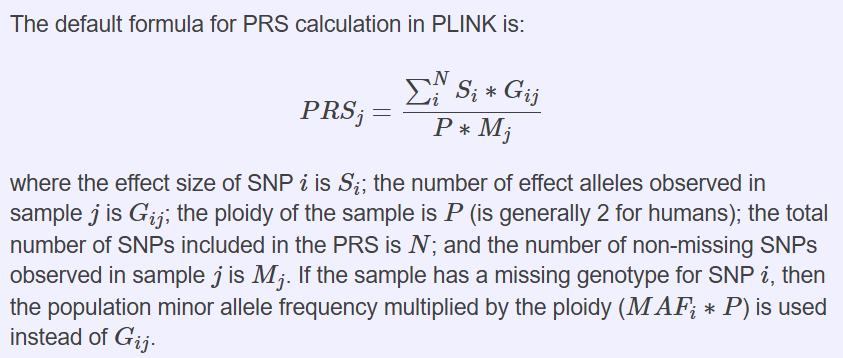

In [20]:
#Y_i = sum_j(X_ij * Beta_j) + error_i
#X^_ij (testing)B^_j = Y^_i=PRS
p_vals = [1, 0.05, 0.01, 0.001, 0.00001]
def prs_gene_pipeline(analysis_df, samples, genotypes, p_val):
    analysis_df = analysis_df[analysis_df['p_val'] <= p_val]
    prs = {}
    for iid in samples['i']:
        numerator = 0
        denominator = 2 * analysis_df.shape[0]
        for snp in analysis_df['i']:
            temp_snp = analysis_df[analysis_df['i']==snp]
            temp_beta = temp_snp['beta'].values[0]
            temp_ea_count = genotypes[iid].iloc[snp]
            numerator += temp_beta * temp_ea_count
        temp_fid = samples[samples['i']==iid]['fid'].values[0]
        
        prs[temp_fid] = numerator / (denominator + 1e-10)
    return prs

In [21]:
valid_expressions = P[P['TargetID']==gene_to_explore][valid_samples['fid']].reset_index(drop=True).T.rename(columns={0:'expression'})
for p in p_vals:
    valid_prs = prs_gene_pipeline(target_gene_analysis, valid_samples, valid_genotypes, p)
    valid_prs_df = pd.DataFrame.from_dict(valid_prs, orient='index').rename(columns={0: f'predicted_{p}'})
    valid_expressions = valid_expressions.merge(valid_prs_df, how='outer', left_index=True, right_index=True)

valid_expressions.head()

,expression,predicted_1,predicted_0.05,predicted_0.01,predicted_0.001,predicted_1e-05
HG00111,2.224927,-0.000567,0.012389,0.095396,0.0,0.0
HG00125,1.935235,0.001361,0.060279,0.204427,0.0,0.0
HG00128,2.081891,0.001886,0.072035,0.218061,0.0,0.0
HG00139,2.173676,0.001308,0.050371,0.218061,0.0,0.0
HG00145,2.787805,0.006433,0.089583,0.204427,0.0,0.0


In [22]:
def r_squared(df, x1, x2):
    temp_r = df[x1].corr(df[x2])
    if np.isnan(temp_r):
        temp_r = 0
    return temp_r ** 2


In [23]:
to_compare = ['predicted_1', 'predicted_0.05', 'predicted_0.01', 'predicted_0.001', 'predicted_1e-05']
valid_r_sq = {}
for c in to_compare:
    temp_p_val = c.split('_')[-1]
    valid_r_sq[temp_p_val] = r_squared(valid_expressions, 'expression', c)

valid_r_sq

{'1': 0.007773170493298755,
 '0.05': 0.010882058964540144,
 '0.01': 0.016763228008557816,
 '0.001': 0,
 '1e-05': 0}

In [24]:
test_expressions = P[P['TargetID']==gene_to_explore][test_samples['fid']].reset_index(drop=True).T.rename(columns={0:'expression'})

test_prs = prs_gene_pipeline(target_gene_analysis, test_samples, test_genotypes, 0.05)
test_prs_df = pd.DataFrame.from_dict(test_prs, orient='index').rename(columns={0: f'predicted'})

test_expressions = test_expressions.merge(test_prs_df, how='outer', left_index=True, right_index=True)

r_squared(test_expressions,'expression', 'predicted')


0.0034114188872773296